# Boundary Equilibrium GAN (BEGAN)

## Theory

A new **equilibrium** enforcing method paired with a loss derived from the **Wasserstein distance** for training auto-encoder based GANs.

+ Equilibrium

In practice it is crucial to maintain a balance between the generator and discriminator losses; we consider them to be at equilibrium when:

$$\mathbb{E}[\mathcal{L}(x)] = \mathbb{E}[\mathcal{L}(G(z))].$$

We can relax the equilibrium with the introduction of a new hyper-parameter $\gamma \in [0, 1]$ defined as

$$\gamma = \frac{\mathbb{E}[\mathcal{L}(G(z))]}{\mathbb{E}[\mathcal{L}(x)]}. \quad (Eq1)$$

In our model, the discriminator has two competing goals: auto-encode real images and discriminate real from generated images. The $\gamma$ term lets us balance these two goals. Lower values of $\gamma$ lead to lower image diversity because the discriminator focuses more heavily on auto-encoding real images. We will refer to $\gamma$ as the diversity ratio. There is a natural boundary for which images are sharp and have details.

+ The BEGAN objective

$$\begin{equation}
		\begin{cases}
		\mathcal{L}_D = \mathcal{L}(x) - k_t \cdot \mathcal{L}(G(z_D)) & \text{for } \theta_D \\
		\mathcal{L}_G = \mathcal{L}(G(z_G)) & \text{for } \theta_G \\
        k_{t+1} = k_t + \lambda_k (\gamma \mathcal{L}(x) - \mathcal{L}(G(z_G))) & \text{for each training step t}
		\end{cases}
\end{equation}$$

We use **Proportional Control Theory** to maintain the equilibrium $\mathbb{E} [\mathcal{L}(G(z))] = \gamma \mathbb{E} [\mathcal{L}(x)]$. This is implemented using a variable $k_t \in [0, 1]$ to control how much emphasis is put on $\mathcal{L}(G(z_D))$ during gradient descent. We initialize $k_0 = 0$. $\lambda_k$ is the proportional gain for $k$; in machine learning terms, it is the learning rate for $k$. In essence, this can be thought of as a form of closed-loop feedback control in which $k_t$ is adjusted at each step to maintain equation Eq1.

In early training stages, G tends to generate easy-to-reconstruct data for the auto-encoder since generated data is close to 0 and the real data distribution has not been learned accurately yet. This yields to $\mathcal{L}(x) > \mathcal{L}(G(z))$ early on and this is maintained for the whole training process by the equilibrium constraint.

In contrast to traditional GANs which require alternating training $D$ and $G$, or pretraining $D$, our proposed method BEGAN requires neither to train stably. Adam was used during training with the default hyper-parameters. $\theta_D$ and $\theta_G$ are updated independently based on their respective losses with separate Adam optimizers.

+ Convergence measure

Determining the convergence of GANs is generally a difficult task since the original formulation is defined as a **zero-sum game**. As a consequence, one loss goes up when the other goes down. The number of epochs or visual inspection are typically the only practical ways to get a sense of how training has progressed.

We derive a global measure of convergence by using the equilibrium concept: we can frame the convergence process as finding the closest reconstruction $\mathcal{L}(x)$ with the lowest absolute value of the instantaneous process error for the proportion control algorithm $\lvert \gamma \mathcal{L}(x) - \mathcal{L}(G(z_G)) \rvert$. This measure is formulated as the sum of these two terms:

$$\mathcal{M}_{global} = \mathcal{L}(x) + \lvert \gamma \mathcal{L}(x) - \mathcal{L}(G(z_G)) \rvert.$$

This measure can be used to determine when the network has reached its final state or if the model has collapsed.

## Advantages and Limitations

+ Balance the generator and discriminator during training.
+ Provide a new approximate convergence measure, fast and stable training and high visual quality.

----

+ Does the discriminator have to be an auto-encoder? Having pixel-level feedback seems to greatly help convergence, however using an auto-encoder has its drawbacks: what latent space size is best for a dataset? When should noise be added to the input and how much? What impact would using other varieties of auto-encoders such VAEs have?
+ More fundamentally, we note that our objective bears a superficial resemblance to the WGAN objective. Is the auto-encoder combined with the equilibrium concept fulfilling a similar bounding functionality as the K-Lipschitz constraint in the WGAN formulation?

## References

D. Berthelot, et al., BEGAN: Boundary Equilibrium Generative Adversarial Networks, 2017.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 1e-3
m = 5
lambd = 1e-3
gamma = 0.5

k_curr = 0

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
k = tf.placeholder(tf.float32)

X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    x_recon = tf.matmul(D_h1, D_W2) + D_b2
    mse = tf.reduce_mean(tf.reduce_sum((x - x_recon)**2, 1))
    
    return mse

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Loss functions
+ We can use some optimization algorithms with different learning rates

In [10]:
D_loss = D_real - k * D_fake
G_loss = D_fake

D_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $d_{steps} = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-BEGAN/'):
    os.makedirs('GAN-BEGAN/')

avg_costs = {'convergence': []} 

i = 0

for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_mb = sample_Z(mb_size, Z_dim)
    
    _, D_real_curr = sess.run([D_solver, D_real], feed_dict={X: X_mb, Z: Z_mb, k: k_curr})
    _, D_fake_curr = sess.run([G_solver, D_fake], feed_dict={Z: Z_mb})

    k_curr = k_curr + lambd * (gamma * D_real_curr - D_fake_curr)

    if it % 1000 == 0:
        measure = D_real_curr + np.abs(gamma * D_real_curr - D_fake_curr)
        
        print('Iter: {}'.format(it))
        print('Convergence measure: {:.4}'. format(measure))
        print('\n')
        
        n_sample = 16

        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-BEGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['convergence'].append(measure / n_sample)

Iter: 0
Convergence measure: 555.8


Iter: 1000
Convergence measure: 31.18


Iter: 2000
Convergence measure: 27.41


Iter: 3000
Convergence measure: 20.56


Iter: 4000
Convergence measure: 19.67


Iter: 5000
Convergence measure: 18.54


Iter: 6000
Convergence measure: 16.41


Iter: 7000
Convergence measure: 14.42


Iter: 8000
Convergence measure: 15.15


Iter: 9000
Convergence measure: 13.15


Iter: 10000
Convergence measure: 13.54


Iter: 11000
Convergence measure: 13.49


Iter: 12000
Convergence measure: 13.94


Iter: 13000
Convergence measure: 14.3


Iter: 14000
Convergence measure: 12.77


Iter: 15000
Convergence measure: 13.17


Iter: 16000
Convergence measure: 13.59


Iter: 17000
Convergence measure: 14.04


Iter: 18000
Convergence measure: 13.15


Iter: 19000
Convergence measure: 12.91


Iter: 20000
Convergence measure: 13.61


Iter: 21000
Convergence measure: 12.93


Iter: 22000
Convergence measure: 13.05


Iter: 23000
Convergence measure: 12.48


Iter: 24000
Convergence measur

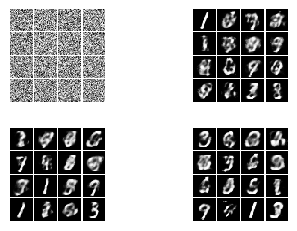

In [12]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-BEGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-BEGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-BEGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-BEGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

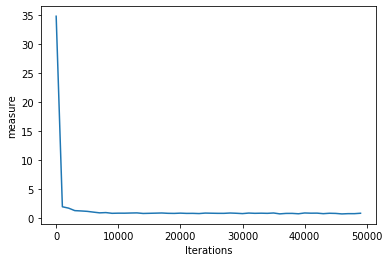

In [16]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['convergence']))*1000, avg_costs['convergence'])
plt.xlabel(r'Iterations')
plt.ylabel(r'measure')
plt.show()